In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


# Reference:
1. https://www.kaggle.com/code/senasudemir/software-defects-prediction#Modelling-with-Conversational-Models
2. https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense

# Based on Synthetic Dataset

In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Scikit-learn modules
from sklearn.impute import SimpleImputer,MissingIndicator,KNNImputer  # Corrected name
from sklearn.model_selection import train_test_split,cross_val_score  # Correct
from sklearn.compose import ColumnTransformer  # Correct module
from sklearn.preprocessing import PowerTransformer,OneHotEncoder,OrdinalEncoder,LabelEncoder,StandardScaler,FunctionTransformer,KBinsDiscretizer,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import Perceptron,LinearRegression,SGDRegressor,Ridge
from mlxtend.plotting import plot_decision_regions

In [3]:
df=pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')

In [4]:
dftest=pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')

# UnderStanding Data

In [5]:
df.columns

Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'],
      dtype='object')

In [6]:
comb=[df,dftest]

## Replacing Column Names

In [7]:
# Loop through each DataFrame in the list
for i in comb:
    i.rename(columns={
        'n': 'noFunctions',
        'v': 'noVertices',
        'l': 'noLoops',
        'd': 'noDecisions',
        'i': 'noInputs',
        'e': 'noExternalDependencies',
        'b': 'noBugs',
        't': 'noTests'
    }, inplace=True)


In [8]:
df.columns

Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'noFunctions', 'noVertices',
       'noLoops', 'noDecisions', 'noInputs', 'noExternalDependencies',
       'noBugs', 'noTests', 'lOCode', 'lOComment', 'lOBlank',
       'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd',
       'branchCount', 'defects'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      101763 non-null  int64  
 1   loc                     101763 non-null  float64
 2   v(g)                    101763 non-null  float64
 3   ev(g)                   101763 non-null  float64
 4   iv(g)                   101763 non-null  float64
 5   noFunctions             101763 non-null  float64
 6   noVertices              101763 non-null  float64
 7   noLoops                 101763 non-null  float64
 8   noDecisions             101763 non-null  float64
 9   noInputs                101763 non-null  float64
 10  noExternalDependencies  101763 non-null  float64
 11  noBugs                  101763 non-null  float64
 12  noTests                 101763 non-null  float64
 13  lOCode                  101763 non-null  int64  
 14  lOComment           

In [10]:
df.isna().sum()

id                        0
loc                       0
v(g)                      0
ev(g)                     0
iv(g)                     0
noFunctions               0
noVertices                0
noLoops                   0
noDecisions               0
noInputs                  0
noExternalDependencies    0
noBugs                    0
noTests                   0
lOCode                    0
lOComment                 0
lOBlank                   0
locCodeAndComment         0
uniq_Op                   0
uniq_Opnd                 0
total_Op                  0
total_Opnd                0
branchCount               0
defects                   0
dtype: int64

In [11]:
dftest.isna().sum()

id                        0
loc                       0
v(g)                      0
ev(g)                     0
iv(g)                     0
noFunctions               0
noVertices                0
noLoops                   0
noDecisions               0
noInputs                  0
noExternalDependencies    0
noBugs                    0
noTests                   0
lOCode                    0
lOComment                 0
lOBlank                   0
locCodeAndComment         0
uniq_Op                   0
uniq_Opnd                 0
total_Op                  0
total_Opnd                0
branchCount               0
dtype: int64

In [12]:
df.describe()

,id,loc,v(g),ev(g),iv(g),noFunctions,noVertices,noLoops,noDecisions,noInputs,...,noTests,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [13]:
df.duplicated().sum()

0

In [14]:
for i in df.columns:
    print(i,df[i].unique())

id [     0      1      2 ... 101760 101761 101762]
loc [2.200e+01 1.400e+01 1.100e+01 8.000e+00 2.300e+01 2.400e+01 3.400e+01
 9.000e+00 1.600e+01 1.900e+01 8.300e+01 6.000e+00 6.600e+01 1.260e+02
 7.000e+00 4.000e+01 5.000e+00 4.000e+00 6.300e+01 4.500e+01 3.200e+01
 1.200e+01 1.300e+01 2.100e+01 5.600e+01 5.400e+01 8.000e+01 2.600e+01
 5.100e+01 2.800e+01 3.700e+01 4.200e+01 1.700e+01 9.700e+01 1.000e+01
 7.400e+01 1.500e+01 3.000e+01 6.200e+01 5.700e+01 1.800e+01 3.900e+01
 2.700e+01 4.900e+01 8.800e+01 1.000e+02 8.900e+01 2.000e+01 3.100e+01
 9.500e+01 4.800e+01 4.700e+01 6.400e+01 7.500e+01 1.010e+02 1.370e+02
 2.500e+01 4.100e+01 1.020e+02 3.600e+01 5.000e+01 3.800e+01 8.500e+01
 4.400e+01 1.120e+02 6.500e+01 6.700e+01 5.900e+01 8.400e+01 7.000e+01
 1.080e+02 5.800e+01 5.260e+02 9.600e+01 8.600e+01 2.900e+01 1.430e+02
 1.190e+02 1.070e+02 9.900e+01 7.800e+01 2.430e+02 4.110e+02 6.100e+01
 5.200e+01 1.290e+02 4.300e+01 9.000e+01 1.320e+02 3.300e+01 1.860e+02
 1.460e+02 5.730e+02 3

# EDA

1. 100000 rows with 21 features is abundant data. We don't need to worry much about overfitting.
2. All 21 features are nonnegative and their distributions are right-skewed, resembling an exponential distribution. A log-transformation is recommended.

## Covariance Analysis

<Axes: >

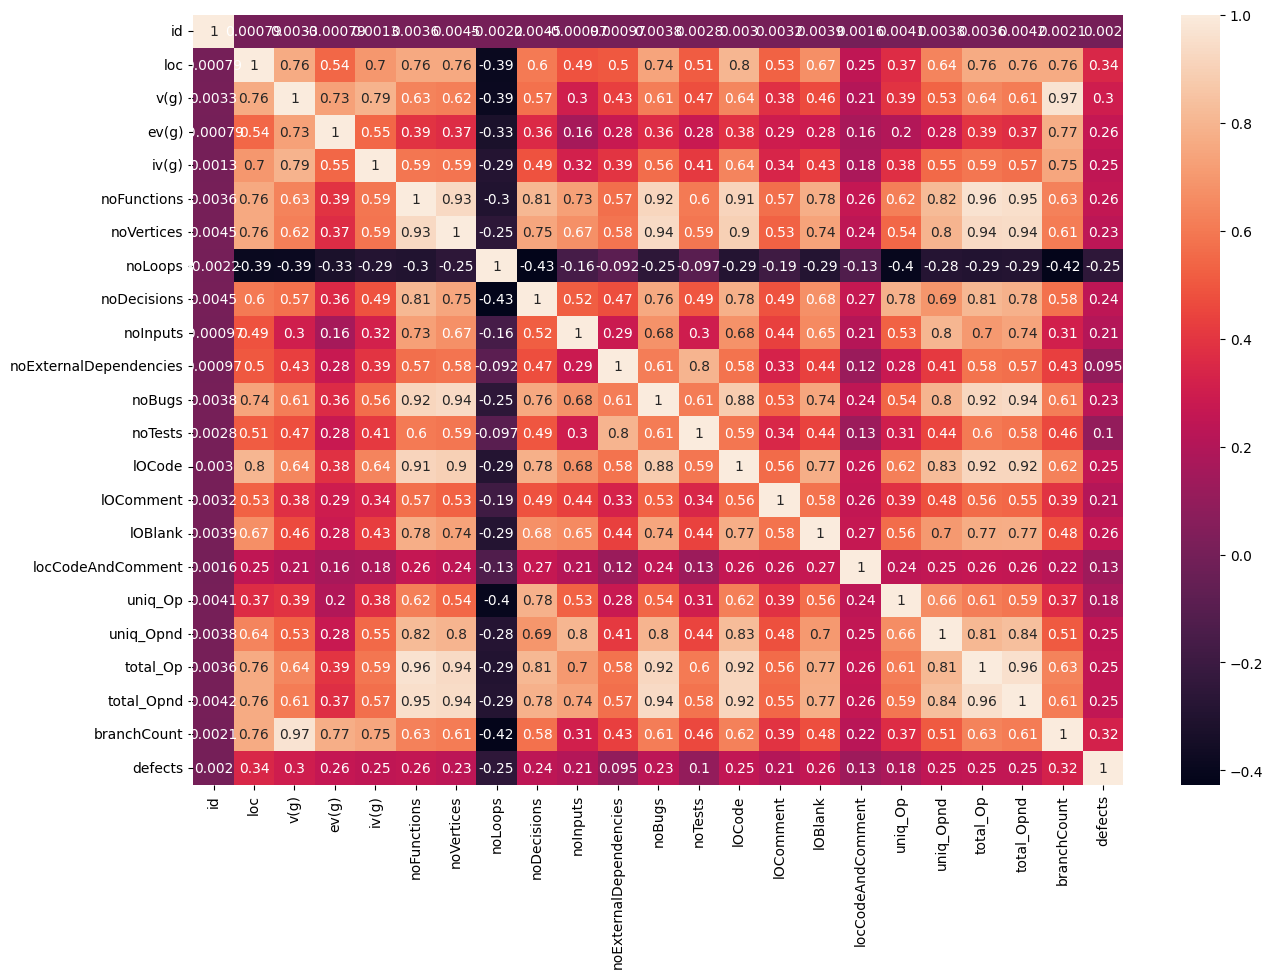

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

## Train Test Split

In [16]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(columns='defects'),df['defects'],test_size=0.2,random_state=42)

In [17]:
comb.extend([xtrain,xtest,ytrain,ytest])

In [18]:
ytrain

41510    False
24079    False
91367     True
6237     False
72207    False
         ...  
6265     False
54886    False
76820    False
860      False
15795    False
Name: defects, Length: 81410, dtype: bool

In [19]:
for i in comb:
    i.drop(columns='id',inplace=True)

## Outlier Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='noBugs', ylabel='Count'>

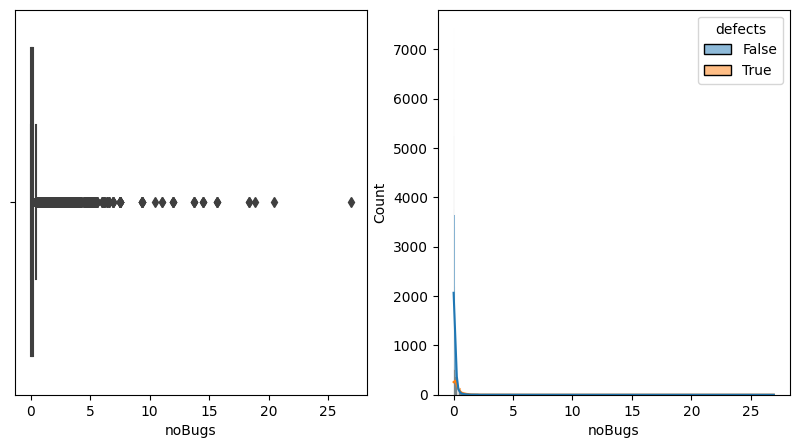

In [20]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
sns.boxplot(data=df,x='noBugs',hue='defects',ax=axes[0])
sns.histplot(data=df,x='noBugs',hue='defects',ax=axes[1],kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='trfTemp__noBugs', ylabel='Count'>

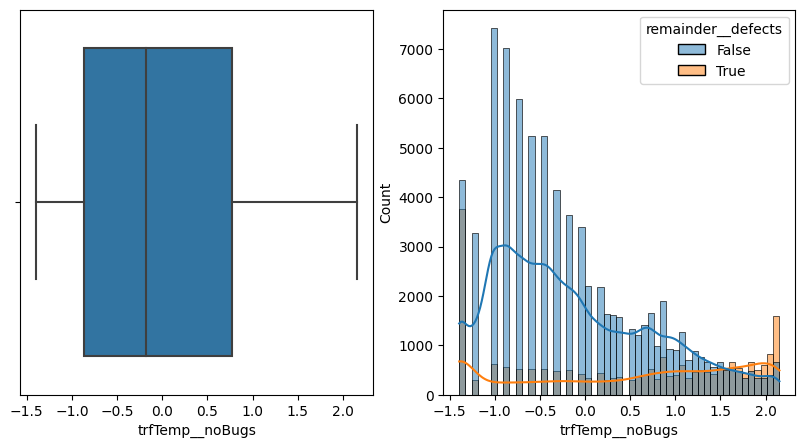

In [21]:
# After Transformation
trfTemp=ColumnTransformer([
    ('trfTemp',PowerTransformer(method='yeo-johnson'),['noBugs'])
],remainder='passthrough')
df2=df.copy()
df2=pd.DataFrame(trfTemp.fit_transform(df2),columns=trfTemp.get_feature_names_out())

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
sns.boxplot(data=df2,x='trfTemp__noBugs',hue='remainder__defects',ax=axes[0])
sns.histplot(data=df2,x='trfTemp__noBugs',hue='remainder__defects',ax=axes[1],kde=True)

### Before Transformation : OUTLIERS After: NO OUTLIERS

## Complete Graphical Analysis

In [22]:
df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'noFunctions', 'noVertices', 'noLoops',
       'noDecisions', 'noInputs', 'noExternalDependencies', 'noBugs',
       'noTests', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'],
      dtype='object')

0 loc


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


1 v(g)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


2 ev(g)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


3 iv(g)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


4 noFunctions


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


5 noVertices


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


6 noLoops


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


7 noDecisions


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


8 noInputs


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


9 noExternalDependencies


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


10 noBugs


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


11 noTests


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


12 lOCode


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


13 lOComment


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


14 lOBlank


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


15 locCodeAndComment


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

16 uniq_Op


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


17 uniq_Opnd


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


18 total_Op


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


19 total_Opnd


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


20 branchCount


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


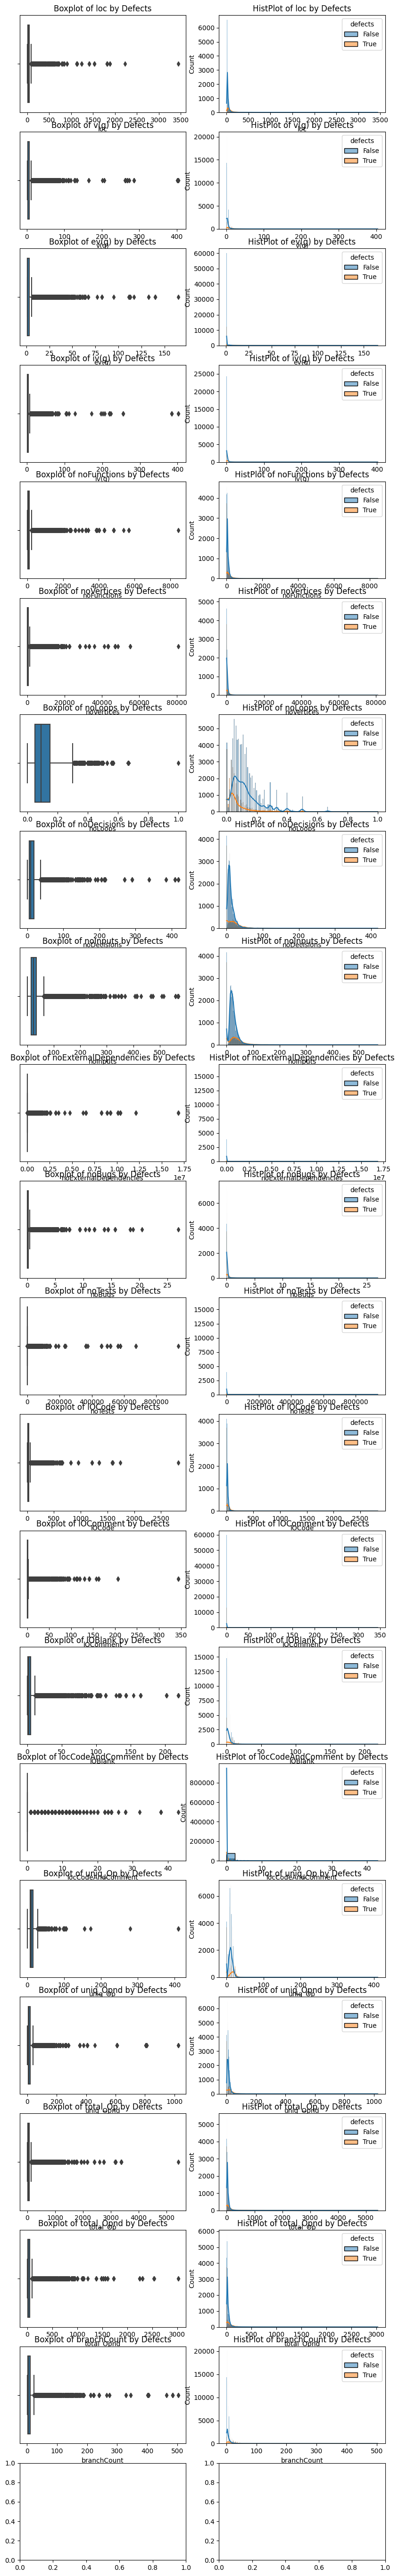

In [23]:
fig,axes=plt.subplots(df.shape[1],2,figsize=(10,70))
axes=axes.flatten()
for ind,attr in enumerate(df.drop(columns='defects').columns):
    print(ind,attr)
    sns.boxplot(data=df,x=attr,hue='defects',ax=axes[2*ind])
    sns.histplot(data=df,x=attr,hue='defects',ax=axes[2*ind+1],kde=True)
    axes[2 * ind].set_title(f'Boxplot of {attr} by Defects')
    axes[2 * ind+1].set_title(f'HistPlot of {attr} by Defects')

Index(['trfTemp__loc', 'trfTemp__v(g)', 'trfTemp__ev(g)', 'trfTemp__iv(g)',
       'trfTemp__noFunctions', 'trfTemp__noVertices', 'trfTemp__noLoops',
       'trfTemp__noDecisions', 'trfTemp__noInputs',
       'trfTemp__noExternalDependencies', 'trfTemp__noBugs',
       'trfTemp__noTests', 'trfTemp__lOCode', 'trfTemp__lOComment',
       'trfTemp__lOBlank', 'trfTemp__locCodeAndComment', 'trfTemp__uniq_Op',
       'trfTemp__uniq_Opnd', 'trfTemp__total_Op', 'trfTemp__total_Opnd',
       'trfTemp__branchCount', 'trfTemp__defects'],
      dtype='object')
0 trfTemp__loc


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

1 trfTemp__v(g)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

2 trfTemp__ev(g)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: Futu

3 trfTemp__iv(g)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

4 trfTemp__noFunctions


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


5 trfTemp__noVertices


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

6 trfTemp__noLoops


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

7 trfTemp__noDecisions


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


8 trfTemp__noInputs


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

9 trfTemp__noExternalDependencies


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

10 trfTemp__noBugs


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

11 trfTemp__noTests


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


12 trfTemp__lOCode


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

13 trfTemp__lOComment


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

14 trfTemp__lOBlank


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


15 trfTemp__locCodeAndComment


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

16 trfTemp__uniq_Op


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


17 trfTemp__uniq_Opnd


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

18 trfTemp__total_Op


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

19 trfTemp__total_Opnd


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

20 trfTemp__branchCount


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

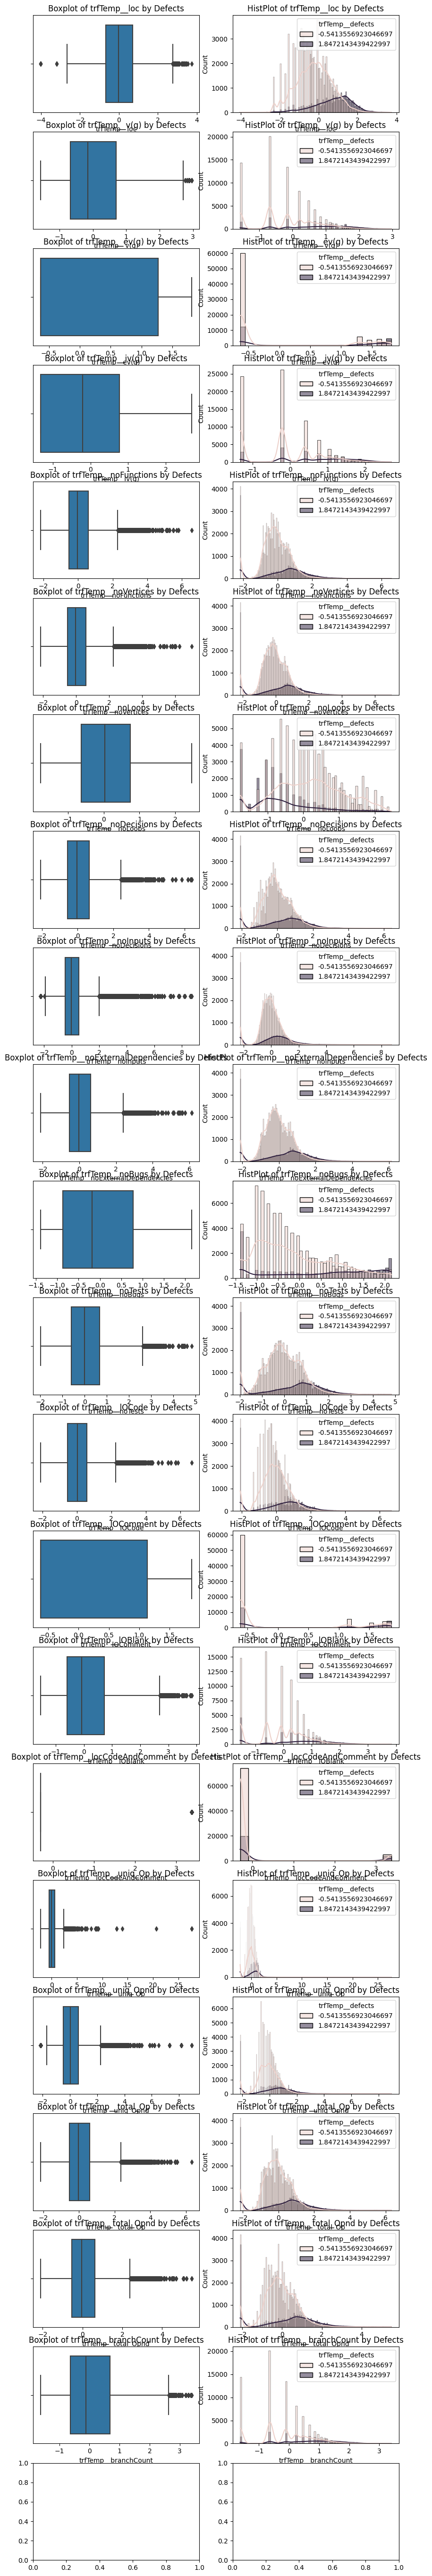

In [24]:
# After Transformation
trfTemp=ColumnTransformer([
    ('trfTemp',PowerTransformer(method='yeo-johnson'),df.columns)
],remainder='passthrough')
df2=df.copy()
df2=pd.DataFrame(trfTemp.fit_transform(df2),columns=trfTemp.get_feature_names_out())
print(df2.columns)
fig,axes=plt.subplots(df.shape[1],2,figsize=(10,70))
axes=axes.flatten()
for ind,attr in enumerate(df2.drop(columns='trfTemp__defects').columns):
    print(ind,attr)
    sns.boxplot(data=df2,x=attr,hue='trfTemp__defects',ax=axes[2*ind])
    sns.histplot(data=df2,x=attr,hue='trfTemp__defects',ax=axes[2*ind+1],kde=True)
    axes[2 * ind].set_title(f'Boxplot of {attr} by Defects')
    axes[2 * ind+1].set_title(f'HistPlot of {attr} by Defects')

In [25]:
df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'noFunctions', 'noVertices', 'noLoops',
       'noDecisions', 'noInputs', 'noExternalDependencies', 'noBugs',
       'noTests', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'],
      dtype='object')

# PCA

In [26]:
pca=PCA()
pca.fit(xtrain)

PCA()

In [27]:
pca.explained_variance_ratio_

array([9.99216993e-01, 7.57862779e-04, 2.49816207e-05, 8.86576846e-08,
       3.43534519e-08, 1.39238238e-08, 8.55737041e-09, 4.94757001e-09,
       4.31308721e-09, 3.01094421e-09, 1.71276453e-09, 9.50144390e-10,
       6.35622740e-10, 3.35124428e-10, 2.88474110e-10, 2.51526022e-10,
       2.08176752e-10, 6.61991757e-11, 2.42186957e-11, 3.99124630e-13,
       1.77749241e-13])

In [28]:
sum=0
for ind,i in enumerate(pca.explained_variance_ratio_):
    sum+=i
    if(sum>0.99):
        print(ind)
        break

0


# Transformers

In [29]:
trf=ColumnTransformer([
    ('transform',PowerTransformer(method='yeo-johnson'),slice(0,df.shape[1]-1)), #avoided Target Column in Cross Validation
    ('ss',StandardScaler(),slice(0,df.shape[1]-1)) #avoided Target Column in Cross Validation
],remainder='passthrough')

In [30]:
df2=df.copy()
pd.DataFrame(trf.fit_transform(df2),columns=trf.get_feature_names_out()).columns

Index(['transform__loc', 'transform__v(g)', 'transform__ev(g)',
       'transform__iv(g)', 'transform__noFunctions', 'transform__noVertices',
       'transform__noLoops', 'transform__noDecisions', 'transform__noInputs',
       'transform__noExternalDependencies', 'transform__noBugs',
       'transform__noTests', 'transform__lOCode', 'transform__lOComment',
       'transform__lOBlank', 'transform__locCodeAndComment',
       'transform__uniq_Op', 'transform__uniq_Opnd', 'transform__total_Op',
       'transform__total_Opnd', 'transform__branchCount', 'ss__loc',
       'ss__v(g)', 'ss__ev(g)', 'ss__iv(g)', 'ss__noFunctions',
       'ss__noVertices', 'ss__noLoops', 'ss__noDecisions', 'ss__noInputs',
       'ss__noExternalDependencies', 'ss__noBugs', 'ss__noTests', 'ss__lOCode',
       'ss__lOComment', 'ss__lOBlank', 'ss__locCodeAndComment', 'ss__uniq_Op',
       'ss__uniq_Opnd', 'ss__total_Op', 'ss__total_Opnd', 'ss__branchCount',
       'remainder__defects'],
      dtype='object')

# Model Selection + Stratified Cross Validation

## Transforming Copied Data

In [31]:
df2=df.copy()
df2=pd.DataFrame(trf.fit_transform(df2),columns=trf.get_feature_names_out())
df2.columns

Index(['transform__loc', 'transform__v(g)', 'transform__ev(g)',
       'transform__iv(g)', 'transform__noFunctions', 'transform__noVertices',
       'transform__noLoops', 'transform__noDecisions', 'transform__noInputs',
       'transform__noExternalDependencies', 'transform__noBugs',
       'transform__noTests', 'transform__lOCode', 'transform__lOComment',
       'transform__lOBlank', 'transform__locCodeAndComment',
       'transform__uniq_Op', 'transform__uniq_Opnd', 'transform__total_Op',
       'transform__total_Opnd', 'transform__branchCount', 'ss__loc',
       'ss__v(g)', 'ss__ev(g)', 'ss__iv(g)', 'ss__noFunctions',
       'ss__noVertices', 'ss__noLoops', 'ss__noDecisions', 'ss__noInputs',
       'ss__noExternalDependencies', 'ss__noBugs', 'ss__noTests', 'ss__lOCode',
       'ss__lOComment', 'ss__lOBlank', 'ss__locCodeAndComment', 'ss__uniq_Op',
       'ss__uniq_Opnd', 'ss__total_Op', 'ss__total_Opnd', 'ss__branchCount',
       'remainder__defects'],
      dtype='object')

In [32]:
# Core models
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Ensemble models
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier,
    StackingClassifier, VotingClassifier
)

# Optional external models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [33]:
models = {
    "LogisticRegression": LogisticRegression(),
    "RidgeClassifier": RidgeClassifier(),
    "SGDClassifier": SGDClassifier(),
    "PassiveAggressive": PassiveAggressiveClassifier(),
    
    "KNeighbors": KNeighborsClassifier(),
    
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "CategoricalNB": CategoricalNB(),

    "DecisionTree": DecisionTreeClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "HistGradientBoosting": HistGradientBoostingClassifier(),

    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
}


In [34]:
for name,model in models.items():
    try:
        scores=cross_val_score(model,df2.drop(columns=['remainder__defects']),df2['remainder__defects'],cv=5,scoring='accuracy')
        scores2=cross_val_score(model,df2.drop(columns=['remainder__defects']),df2['remainder__defects'],cv=5,scoring='f1_weighted')
        print(name,"Accuracy: ",scores.mean(),"F1 Weighted: ",scores2.mean())
    except Exception as e:
        print(f"{name} failed:")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression Accuracy:  0.8129378855109828 F1 Weighted:  0.7919361958832539
RidgeClassifier Accuracy:  0.8105205026911799 F1 Weighted:  0.7830340842133008
SGDClassifier Accuracy:  0.8006052161271793 F1 Weighted:  0.7681234014678214
PassiveAggressive Accuracy:  0.6834711258434851 F1 Weighted:  0.7335077915509975
KNeighbors Accuracy:  0.7898351746933912 F1 Weighted:  0.7758980369147627
GaussianNB Accuracy:  0.8015486693275635 F1 Weighted:  0.7918611195734179
MultinomialNB failed:
BernoulliNB Accuracy:  0.6874895940425081 F1 Weighted:  0.7078318319051979
ComplementNB failed:
CategoricalNB failed:
DecisionTree Accuracy:  0.7215687050446413 F1 Weighted:  0.7235693522171724
LDA Accuracy:  0.8132621654102264 F1 Weighted:  0.7960686071768786
QDA Accuracy:  0.7964878990572682 F1 Weighted:  0.755107976651611
GradientBoosting Accuracy:  0.8149621971920447 F1 Weighted:  0.7972755522078272
AdaBoost Accuracy:  0.8133211320198497 F1 Weighted:  0.7932110624389989
Bagging Accuracy:  0.79369710401

# Final Pipeline

In [35]:
pipe=Pipeline([
    ('trf',trf),
    ('model',GradientBoostingClassifier())
])

In [36]:
# pipe.fit(xtrain,ytrain)

In [37]:
# yPred=pipe.predict(xtest)

In [38]:
# from sklearn.metrics import f1_score

In [39]:
# accuracy_score(yPred,ytest)

In [40]:
pipe.fit(df.drop(columns=['defects']),df['defects'])

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transform',
                                                  PowerTransformer(),
                                                  slice(0, 21, None)),
                                                 ('ss', StandardScaler(),
                                                  slice(0, 21, None))])),
                ('model', GradientBoostingClassifier())])

In [41]:
yPred=pipe.predict(dftest)

In [42]:
submission=pd.DataFrame({'defects':yPred})

In [43]:
submission.to_csv('/kaggle/working/submission.csv', index=False)